In [1]:
import os
import uuid
import asyncio
from typing import TypedDict, List
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, END
from IPython.display import Image, display

load_dotenv(override=True)
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

llm = ChatOpenAI(
    model="gpt-5-nano",
    temperature=0,
    api_key=OPENAI_API_KEY,
    streaming=False
)

streaming_llm = ChatOpenAI(
    model="gpt-5-nano",
    temperature=0,
    api_key=OPENAI_API_KEY,
    streaming=True
)

In [2]:
class BlackboardState(TypedDict):
    trace_id: str
    problem: str
    blackboard: List[str]
    final_answer: str

In [3]:
async def initialize_board(state: BlackboardState):

    return {
        "blackboard": [f"Problem: {state['problem']}"]
    }

In [4]:
async def domain_specialist(state: BlackboardState):

    context = "\n".join(state["blackboard"])

    prompt = f"""
    Analyze the problem from a domain knowledge perspective.

    Current Blackboard:
    {context}
    """

    response = await llm.ainvoke([HumanMessage(content=prompt)])

    updated_board = state["blackboard"] + [f"Domain Insight: {response.content}"]

    return {"blackboard": updated_board}

In [5]:
async def risk_specialist(state: BlackboardState):

    context = "\n".join(state["blackboard"])

    prompt = f"""
    Identify potential risks and constraints.

    Current Blackboard:
    {context}
    """

    response = await llm.ainvoke([HumanMessage(content=prompt)])

    updated_board = state["blackboard"] + [f"Risk Insight: {response.content}"]

    return {"blackboard": updated_board}

In [6]:
async def optimization_specialist(state: BlackboardState):

    context = "\n".join(state["blackboard"])

    prompt = f"""
    Suggest optimizations and improvements.

    Current Blackboard:
    {context}
    """

    response = await llm.ainvoke([HumanMessage(content=prompt)])

    updated_board = state["blackboard"] + [f"Optimization Insight: {response.content}"]

    return {"blackboard": updated_board}

In [7]:
async def final_synthesizer(state: BlackboardState):

    context = "\n\n".join(state["blackboard"])

    prompt = f"""
    Based on the full blackboard context below,
    provide a clear final solution summary:

    {context}
    """

    print("\n--- Final Synthesized Solution ---\n")

    final_text = ""

    async for chunk in streaming_llm.astream(
        [HumanMessage(content=prompt)]
    ):
        if chunk.content:
            print(chunk.content, end="", flush=True)
            final_text += chunk.content

    return {"final_answer": final_text}

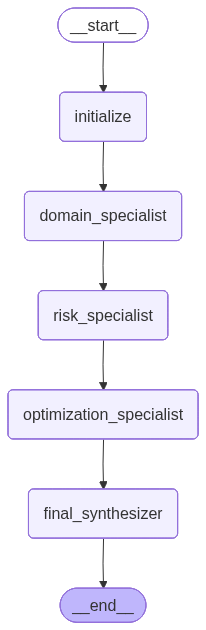

In [8]:
workflow = StateGraph(BlackboardState)

workflow.add_node("initialize", initialize_board)
workflow.add_node("domain_specialist", domain_specialist)
workflow.add_node("risk_specialist", risk_specialist)
workflow.add_node("optimization_specialist", optimization_specialist)
workflow.add_node("final_synthesizer", final_synthesizer)

workflow.set_entry_point("initialize")

workflow.add_edge("initialize", "domain_specialist")
workflow.add_edge("domain_specialist", "risk_specialist")
workflow.add_edge("risk_specialist", "optimization_specialist")
workflow.add_edge("optimization_specialist", "final_synthesizer")
workflow.add_edge("final_synthesizer", END)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
async def run():

    initial_state = {
        "trace_id": str(uuid.uuid4()),
        "problem": "Design a scalable AI platform for autonomous vehicles",
        "blackboard": [],
        "final_answer": ""
    }

    await graph.ainvoke(initial_state)

await run()


--- Final Synthesized Solution ---

Final solution summary

Goal
Design a scalable, safety-first AI platform for autonomous vehicles (AVs) that meets real-time constraints, regulatory requirements, and fleet-scale data needs. The platform spans edge and cloud, enforces modular contracts between subsystems, enables rigorous safety cases, and supports continuous ML lifecycle management, simulation-driven validation, and secure operations.

Key architectural blueprint
- Edge-cloud continuum
  - Edge (real-time loop): perception, localization (HD maps + SLAM), prediction (other agents), planning, and control with deterministic latency budgets. Local compute handles the safety-critical path; sensors feed the fast loop with minimal jitter.
  - Cloud/central: training on diverse, large-scale data; global model updates; map maintenance and dynamic world-model updates; fleet analytics; synthetic data generation and digital twins; governance and compliance tooling.
- Core subsystems and respons